# Learning about Kalman filter / Multivariate Normal Distribution

**Resources**

`Kalman Filter from Ground Up`; author Alex Becker; https://www.kalmanfilter.net

**Overview**

This notebook covers the properties of the `multivariate normal distribution`. In large part the notebook is inspired by
chapter 7.3 of the book `Kalman Filter from Ground Up`.

---


## Covariance

The covariance provides a measure of the correlation of two or more random variables.

In its simplest form the properties of the covariance is studied using **two** random variables.

**Data Sets / uncorrelated**

Two example 2D data sets are created, displayed and it is shown numerically, that the x-y coordinates of the data set are uncorrelated.

Each data set shall have $N=10000$ data points $(x_n, y_n)$. $x_n$ and $y_n$ are random variables.

For the first data set we assume that random variables $x_n$ and $y_n$ are drawn from uniform distributions. $x_n$ is in the interval $ -2, 3$ and $y_n$ in the interval $-3, 1$.

For the second data set we assume that random variables $x_n$ and $y_n$ are drawn from normal distributions. The distribution for $x_n$ has mean $\mu_x = 1$ and standard deviation $\sigma_x = 1$. The distribution for $y_n$ has mean $\mu_y = 2$ and standard deviation $\sigma_y = 0.5$. 

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [25]:
# creating the data sets

N = 10000
x1 = stats.uniform.rvs(loc=-2 , scale=5, size=N) 
y1 = stats.uniform.rvs(loc=-3 , scale=4, size=N)

x2 = stats.norm.rvs(loc=1, scale=1, size=N)
y2 = stats.norm.rvs(loc=2, scale=0.5, size=N)

var_x1 = np.var(x1)
var_y1 = np.var(y1)
cov_xy1 = np.cov(x1, y1)
trace_1 = np.trace(cov_xy1)

var_x2 = np.var(x2)
var_y2 = np.var(y2)
cov_xy2 = np.cov(x2, y2)
trace_2 = np.trace(cov_xy2)

print(f"var_x1: {var_x1:.3e}; var_y1: {var_y1:.3e}; var_x1+var_y1: {var_x1 + var_y1:.3e}; cov_xy1: {cov_xy1}; trace(cov_xy1):{trace_1:.3e}")
print(f"var_x2: {var_x2:.3e}; var_y2: {var_y2:.3e}; var_x2+var_y2: {var_x2 + var_y2:.3e}; cov_xy2: {cov_xy2}; trace(cov_xy2):{trace_2:.3e}")

var_x1: 2.082e+00; var_y1: 1.330e+00; var_x1+var_y1: 3.411e+00; cov_xy1: [[2.08176552 0.01043735]
 [0.01043735 1.32971708]]; trace(cov_xy1):3.411e+00
var_x2: 1.004e+00; var_y2: 2.473e-01; var_x2+var_y2: 1.251e+00; cov_xy2: [[1.00401276 0.00972885]
 [0.00972885 0.24731779]]; trace(cov_xy2):1.251e+00


**Notes**

Apart from numerical artifacts / rounding errors the trace of the covariance matrix is identical to the sum of variances. This is the expected result because of the *uncorrelatedness* of the components of each data set.

Ideally the off-diagonal elements of the correlation matrix should be $0$. Due to numerical effects these elements are quite small.

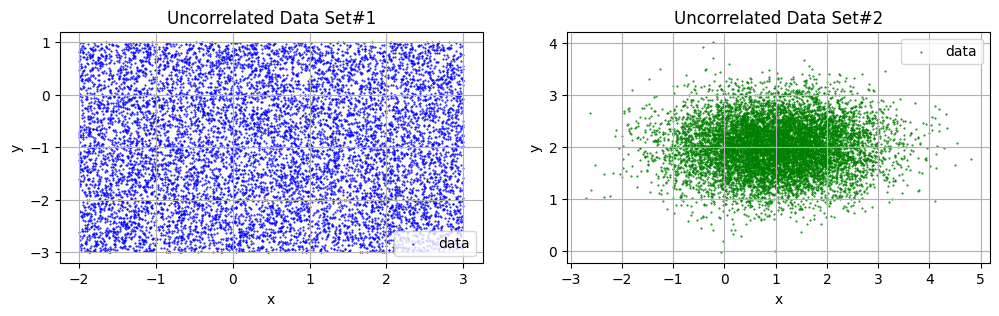

In [26]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

ax1[0].scatter(x1, y1, color='b', s=1,  marker='.', label='data')
ax1[0].set_xlabel('x')
ax1[0].set_ylabel('y')
ax1[0].set_title('Uncorrelated Data Set#1')
ax1[0].legend()
ax1[0].grid(True)

ax1[1].scatter(x2, y2, s=1, color='g', marker='.', label='data')
ax1[1].set_xlabel('x')
ax1[1].set_ylabel('y')
ax1[1].set_title('Uncorrelated Data Set#2')
ax1[1].legend()
ax1[1].grid(True)



**Data Sets / correlated**

Here we create a data set with uncorrelated components and another one which is correlated. The correlation is accomplished via a mixing process.

**recipe**

Generate a random vector $\mathbf{x}[k]$ with two elements $x_1[k], \ x_2[k]$:

$$
\mathbf{x}[k] = \left[\begin{array}{c}
x_1[k] \\ x_2[k]
\end{array}\right] : k := 1, ..., K
$$

There shall be `K` samples from this vector. These sample are stored in a matrix $\mathbf{X} : \ \in \mathbb{R}^{2 \times K}$

$$
\mathbf{X} = \left[\begin{array}{cccc}
| & | & & | \\
\mathbf{x}[1] & \mathbf{x}[2] & \cdots & \mathbf{x}[K] \\
| & | & & |
\end{array}\right] = \left[\begin{array}{cccc}
x_1[1] & x_1[2] & \cdots & x_1[K] \\
x_2[1] & x_2[2] & \cdots & x_2[K]
\end{array}\right]
$$

The matrix $\mathbf{X}$ is right multiplied to a weighting matrix $\mathbf{W} : \ \in \mathbb{R}^{2 \times 2}$ to obtain a new random matrix $\mathbf{Y}$:

$$
\mathbf{W} = \left[\begin{array}{cc}
w_{1,1} & w_{1,2} \\
w_{2,1} & w_{2,2}
\end{array}\right]
$$

$$
\mathbf{y} = \mathbf{W} \cdot \mathbf{X}
$$

The covariance of matrices $\mathbf{X}$ and $\mathbf{Y}$ are computed. While the covariance matrix of $\mathbf{X}$ has only significant entries for the main diagonal, the covariance of $\mathbf{Y}$ has significant entries everywhere due to the processing of the weighting matrix.

A scatter plot of the data in the rows of matrix $\mathbf{X}$ show the de-correlation of samples. However a scatter plot of rows of matrix $\mathbf{Y}$ shows a diagonal orientation due to the mutual correlation.

In [30]:
# two independent random variables
K = 100000
x1 = np.random.randn(K)
x2 = np.random.randn(K)
# each row represents a series of randomly distributed numbers 
Xmat = np.vstack((x1, x2))

# weighting matrix: defines the mixing process
Wmat = np.array([[1, 2],[3, 1]])

# build a new data set by mixing 
Ymat = Wmat @ Xmat

# compute covariance matrices
Cmat_x = np.cov(Xmat)
Cmat_y = np.cov(Ymat)

print("covariance matrices\n")
print(f"Cmat_x  :\n{Cmat_x}\n")
print(f"Cmat_y  :\n{Cmat_y}")

covariance matrices

Cmat_x  :
[[ 1.00337893 -0.00484875]
 [-0.00484875  0.98883462]]

Cmat_y  :
[[4.93932237 4.95386473]
 [4.95386473 9.99015244]]


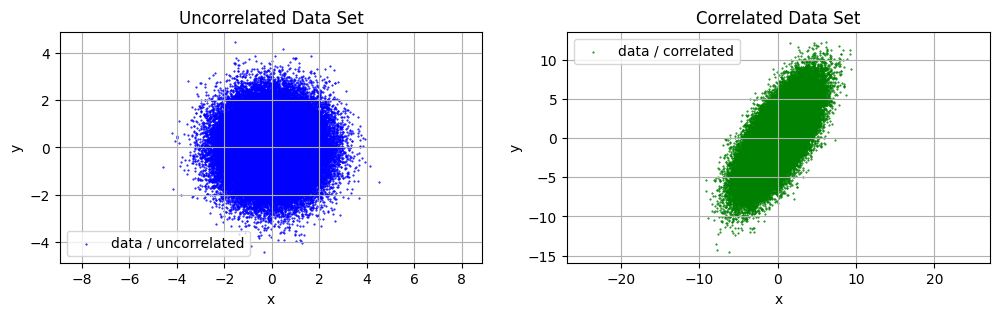

In [31]:
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

ax2[0].scatter(Xmat[0,:], Xmat[1,:], color='b', s=1,  marker='.', label='data / uncorrelated')
ax2[0].set_xlabel('x')
ax2[0].set_ylabel('y')
ax2[0].set_title('Uncorrelated Data Set')
ax2[0].legend()
ax2[0].axis('equal')
ax2[0].grid(True)

ax2[1].scatter(Ymat[0,:], Ymat[1,:], s=1, color='g', marker='.', label='data / correlated')
ax2[1].set_xlabel('x')
ax2[1].set_ylabel('y')
ax2[1].set_title('Correlated Data Set')
ax2[1].legend()
ax2[1].axis('equal')
ax2[1].grid(True)


## The multivariate normal distribution

In one dimension the normal distribution has a probability density function $p(x)$ defined by this formula:

$$
p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \cdot exp\left[-\frac{\left(x - \mu \right)^2}{2 \sigma^2}  \right]
$$

In more than one dimension the probability density of the multivariate normal distribution becomes:

$$
p(x) = \frac{1}{\sqrt{(2\pi)^n |\mathbf{\Sigma}|}} \cdot exp\left[-\frac{1}{2} \cdot \left(\mathbf{x} - \mathbf{\mu} \right)^T \cdot \mathbf{\Sigma^{-1}} \cdot \left(\mathbf{x} - \mathbf{\mu} \right)  \right]
$$

| property  | description |
|-----------|-------------|
| $\mathbf{\Sigma}$ | covariance matrix $\ \in \mathbb{R}^{n \times n}$|
| $|\mathbf{\Sigma}|$ | determinant of covariance matrix |
| $\mathbf{\Sigma^{-1}}$ | inverse of covariance matrix |
| $\mathbf{x}$ | vector $\ \in \mathbb{R}^{n \times 1}$|
| $\mathbf{\mu}$ | vector $\ \in \mathbb{R}^{n \times 1}$ of mean values of each component of vector $\mathbf{x}$ |


But before we look at some applications which involve the multivariate normal distribution we need to know some more details about the concept of 
covariance and it generalisation to its matrix equivalent.

The material is covered in a separate notebook.